In [57]:
import imageio
import numpy as np
from numpy.fft import fft2, ifft2
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import math
import sys
import random
import Levenshtein

mpl.rcParams['figure.figsize'] = [18, 16]

Obrazki mogą być wczytywane w różnych konfiguracjach. W algorytmie chcemy otrzymać macierz 2d więc transformujemy kolory rgb do pojedynczych liczb. Pierwsza z funkcji transformuje do grayscale, druga natomiast zwraca uwagę przede wszystkim na kolor czerwony i zielony (do rozpoznawania ryb).  

In [6]:
def rgb2gray(rgb):
    return np.round(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]))

def rgb2r(rgb):
    return np.round(np.dot(rgb[...,:3], [5, 0, 5]))

Definijemy algorytm obliczania korelacji pomiędzy modelem, a obrazkiem. Obliczamy w nim splot za pomocą fft, a następnie skalujemy wyniki i zostawiamy tylko te które przekraczają próg korelacji. Do celów drugiego zadania umożliwiamy także zwrócenie obliczonej korelacji.

In [7]:
def match(image, model, correlation_threshold = .95, with_correlation = False):
    f_model = np.zeros(image.shape)
    f_model[:model.shape[1], :model.shape[0]] = np.rot90(model)
    res = np.real(ifft2(fft2(image) * fft2(np.rot90(model,2), tuple(image.shape))))
    maxi = np.amax(res)
    mini = np.amin(res)
    if not with_correlation:
        res = res/(maxi-mini)
        for i in range(len(res)):
            for j in range(len(res[i])):
                res[i][j] = 1 if res[i][j] > correlation_threshold else 0
        return res
    else:
        res2 = np.zeros((*res.shape, 2))
        rng = (maxi-mini)
        for i in range(len(res)):
            for j in range(len(res[i])):
                res2[i][j][0] = 1 if res[i][j]/rng > correlation_threshold else 0
                res2[i][j][1] = res[i][j]
        return res2

Poniższe funkcje pozwalają nam zaznaczyć dopasowania na obrazku.

In [8]:
def add_match_on(matched, model, i, j):
    sh = model.shape
    matched[i-sh[0]:i, j-sh[1]:j] = np.ones(sh[:2])
            
def mark_matches(model, res):
    matched = np.zeros(res.shape)
    # add model in places where there is a result
    for i in range(len(res)):
        for j in range(len(res[i])):
            if res[i][j] == 1:
                add_match_on(matched, model, i, j)
                
    return matched

In [9]:
def show_matches(image, matched):
    res = deepcopy(image)
    for i in range(len(matched)):
        for j in range(len(matched[i])):
            if matched[i][j] == 1:
                res[i][j] = 127
    imageio.imwrite('picture_out.png', res)            
    plt.imshow(res)

# Rozpoznawanie wzorców

W pierwszym zadaniu używamy operacji liczenia splotu do rozpoznania liter "e" w zadanym tekście. Obracamy kolory obrazka tak, aby tło było czarne (wartość 0) przez to nie wpływa ono na obliczenia i liczymy splot, a następnie dopasowujemy wzorce powyżej 98%. 

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


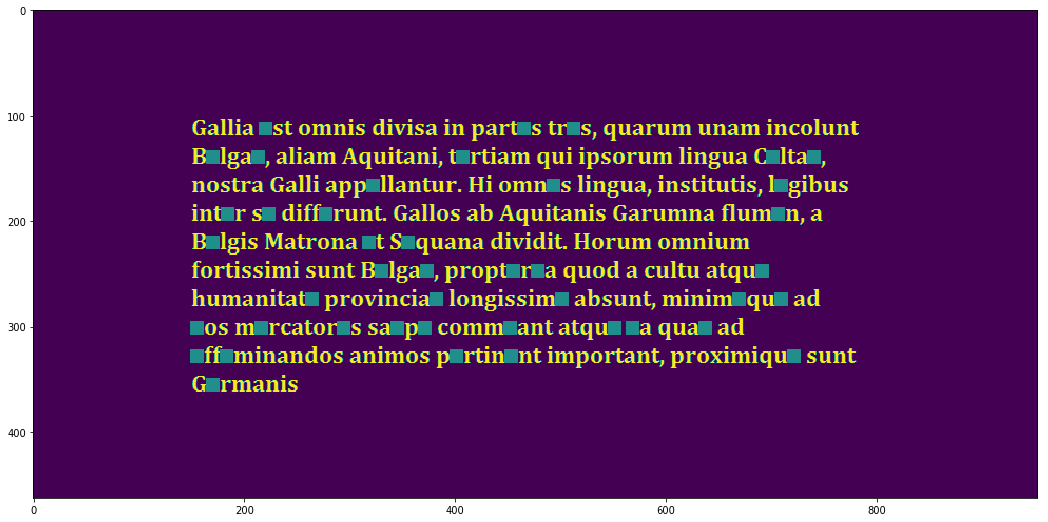

In [10]:
im = rgb2gray(imageio.imread('galia.png'))
wz = rgb2gray(imageio.imread('galia_e.png'))
im = 255 - im
wz = 255 - wz
res = match(im, wz, 0.98)
res = mark_matches(wz, res)
show_matches(im, res)

Algorytm bez problemu rozpoznał wszystkie wystąpienia zadanego wzorca w tekście. Wynika to z bardzo dobrej jakości obrazka i dużego kontrastu pomiędzy tłem, a napisem.

Analogicznie próbujemy rozpoznać poszczególne ryby w większej grupie.

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


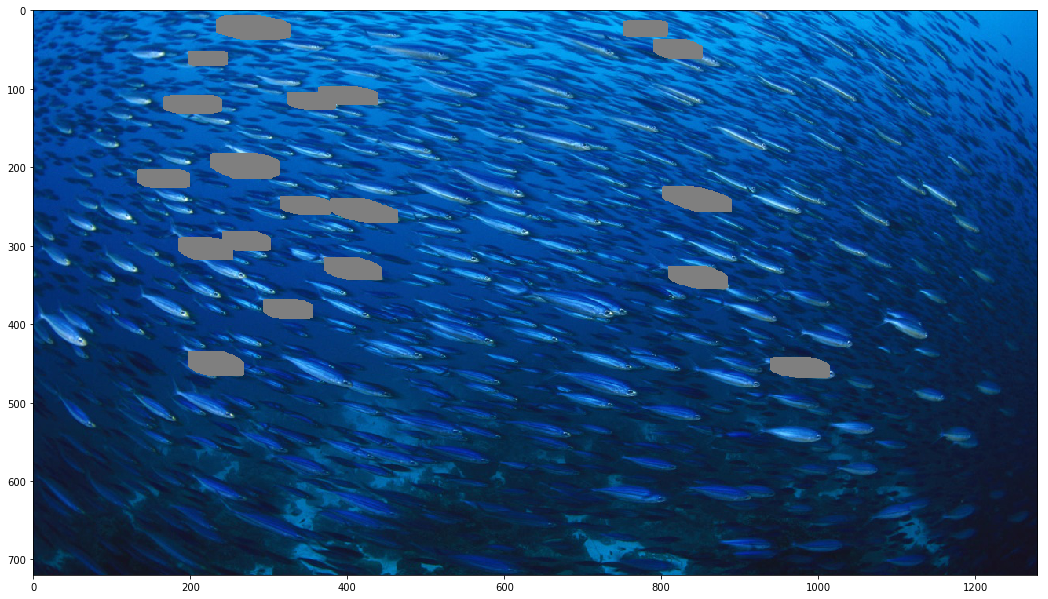

In [123]:
im = imageio.imread('school.jpg')
wz = imageio.imread('fish.png')
res = match(rgb2r(im), rgb2r(wz), 0.87)
res = mark_matches(wz, res)
show_matches(im, res)

Widzimy, że w tym przypadku algorytm nie zadziałał już aż tak dobrze. Znalazł on tylko kilka ryb, reszta została pominięta, nawet pomimo mniejszego progu akceptacji niż poprzednio. Wynika to z faktu, że ryby tutaj są poobracane oraz w różnych odcieniach niebieskiego, przez co te lepsze dopasowania odrzucają te gorsze.

# OCR

W tym zadaniu będziemy starali się analizować zadany obrazek tak aby odczytać zawarty na nim tekst. Na początku definiujemy alfabet złożony z małych liter alfabetu angielskiego, cyfr oraz znaków ".", "?" i "!"

In [12]:
alphabet = [chr(a) for a in range(97,123)] # small letters
alphabet += [chr(a) for a in range(48, 58)] # digits
alphabet += [chr(33),chr(46), chr(63)] # chars

Następujące funkcje pozwolą nam łatwo generować obrazek z zadanym tekstem oraz obrazki z wzorcami liter dla zadanej czcionki.

In [13]:
def letter_file(l, font):
    f = font[:font.rfind('.')]
    return "font/"+f+l+".png"

In [14]:
def generate_alphabet(font, font_size = 40):    
    for l in alphabet:
        image_font = ImageFont.truetype(font=font, size=font_size)
        im = Image.new("L", image_font.getsize(l), color=255)
        d = ImageDraw.Draw(im)
        d.text((0,0), l, font=image_font)
        im.save(letter_file(l, font))

In [39]:
def generate_ideal_text(font, text, size,font_size = 40):
    image_font = ImageFont.truetype(font=font, size=font_size)
    s = (size[0] + font_size/8, size[1] + font_size/8)
    im = Image.new("L", size, color=255)
    d = ImageDraw.Draw(im)
    d.text((0,0), text, font=image_font)
    f = font[:font.rfind('.')]
    im.save("font/"+f+"model_ideal.png")

Aby rozpoznać tekst znajdujący się na obrazku będziemy starali się dopasować każdy znak po kolei do zadanego obrazka licząc splot. Następnie postaramy się ułożyć zadane znaki w tekst. 

Poniższa funkcja dla łączy rezultat ogólny z rezultatem uzyskanym dla zadanej litery. 

In [16]:
def mark_recognition(res, l_res, l, ms):
    for i in range(0,len(l_res)):
        for j in range(0,len(l_res[i])):
            cut = 0
            if l_res[i][j][0] == 1 and l_res[i,j,1] > res[i,j,1]:
                res[i,j,0] = l
                res[i,j,1] = l_res[i,j,1]
                res[i,j,2] = ms[1]


Gdy otrzymamy już wynik całkiem prawdopodobne, że początki danych liter które na orginalnym obrazku są w jednej linii znajdą się w różnych wierszach macierzy. Scalamy je znajdując lokalne maksima (względem ilości wystąpień dowolnych liter w wierszu) i przesuwając litery z zadanego otoczenia do tego wiersza. 

In [ ]:
def reduce_to_line(res, i, sur):
    for j in range(i-sur, i+sur):
        for k in range(len(res[j])):
            if i != j and res[j,k,0] > 0:
                if res[j,k,1] > res[i,k,1]:
                    res[i,k] = res[j,k]
                res[j,k] = [0,0,0,0]  
                
def reduce_lines(res):
    cnt = [len(np.where(i > 0)[0]) for i in res]
    sur = 22
    for i in range(sur, len(cnt)-sur):
        if cnt[i] > max(np.max(cnt[i-sur:i]), np.max(cnt[i+1:i+sur])):
            reduce_to_line(res, i, sur)
         

Częstym problemem jest dopasowywanie w jednym miejscu (lub niewielkim otoczeniu) innej, podobnej litery. Przykładem może być na podobieństwo c do o w czcionce Arial. Innym również znaczącym problemem jest występowanie znaków, które orginalnie nie występują w tekście. Ponieważ bieżemy korelację powyżej 99% dla zadanej litery to każda z liter zostanie gdzieś dopasowana. Zadaniem powyższej funkcji jest wyeliminowanie obu wspomnianych problemów przez wybranie z danego otoczenia litery z najwyższą z korelacji.

In [18]:
def check_cor(res, i, j):
    sur = int(res[i,j,2]*3/4)
    for k in range(max(0, j-sur), min(j+sur, len(res[i]))):
        if res[i,k,1] > res[i,j,1]:
            return False
    return True
    
def apply_filter(res):
    fres = []
    space_width = 10
    for i in range(len(res)):
        row = []
        last = -1
        for j in range(len(res[i])):
            if res[i,j,0] > 0 and check_cor(res, i, j):
                if last != -1 and j - last >= space_width + res[i,j,2]:
                    row.append([32, 5e6, space_width])
                last = j
                row.append(res[i][j])
        if len(row) > 0:
            fres.append(row)
            
    return fres 

Ostatnią pomocniczą funkcją jest funkcja transformująca otrzymaną macierz do tekstu.

In [19]:
def to_text(res):
    text = ""
    cor = 0
    for i in res:
        line = ""
        for j in i:
            if j[0] > 0:
                #line += "("+chr(int(j[0]))+","+str(j[1])+","+str(z)+") "
                line += chr(int(j[0]))
                cor += j[1]
        if line != "":
            text += line + "\n"
    return (text, cor)

W poniższej funkcji dopasowujemy wszystkie znaki po kolei i aplikujemy wyżej wymienione funkcje.

In [20]:
def recognize(image, font):
    image = 255 - deepcopy(image)
    res = np.zeros((*image.shape, 4))
    for l in alphabet:
        model = 255 - imageio.imread(letter_file(l, font))
        l_res = match(image, model, 0.99, True)
        mark_recognition(res, l_res, ord(l), model.shape)
    reduce_lines(res)
    res = apply_filter(res)
    return to_text(res)

W celu obliczenia dokładności rozpoznanego tekstu możemy wykorzystać metrykę Levenshtein'a (https://pl.wikipedia.org/wiki/Odleg%C5%82o%C5%9B%C4%87_Levenshteina). Pozwala nam ona określić odległość między słowami. Dokładność względem modelu definijemy jako 1 - odleglosc/(2*dlugosc_modelu). Długość przemnożyłem przez 2 ze względu na operacje do oblicznia wspomnianej metryki.

In [91]:
model_text = "lorem ipsum dolor sit\namet. aut ter init iun 873 wertan\nmana sola et ce tera axraten?\nbuxtaj!"

def accuracy(text, model):
    return 1 - Levenshtein.distance(res[0], model)/(2*len(model))

## Przypadek optymistyczny

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


lorem ipsum do or sit
amet. aut ter init iun 873 wertan
mana so a et ce tera axraten?
buxtaj
 0.9838709677419355


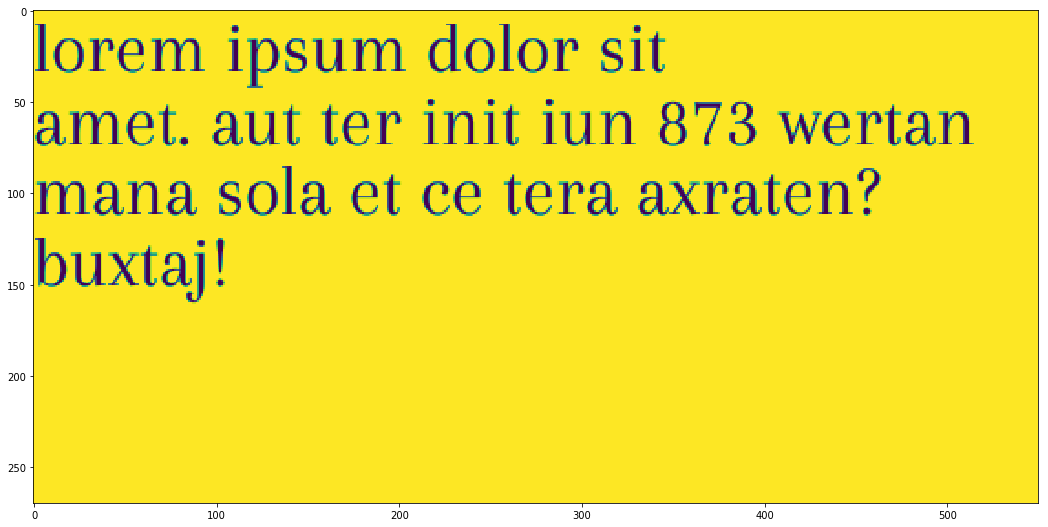

In [103]:
font = 'arapey-regular.ttf'
generate_alphabet(font)
generate_ideal_text(font, model_text, (550, 270))
im = imageio.imread("font/arapey-regularmodel_ideal.png")
res = recognize(im, font)
plt.imshow(im)
print(res[0], accuracy(res[0], model_text))

Dla zadanego przeze mnie wzorca i czcionki Arapey algorytm uzyskuje zadowalającą dokładność na poziomie 98%. Widzimy, że została pominięta jedna litera "l" oraz jest różnica w znaku nowej linii na końcu tekstu.

## Czcionka bezszeryfowa

Trudniejszym przypadkiem może być czcionka bezszeryfowa ze względu na większe podobieństwo liter.

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


lorem ipsum dolor sit ..........
amet aut ter init iun 873 wertar
mana sola et ce tera axraten?
buxtaj!
 0.9247311827956989


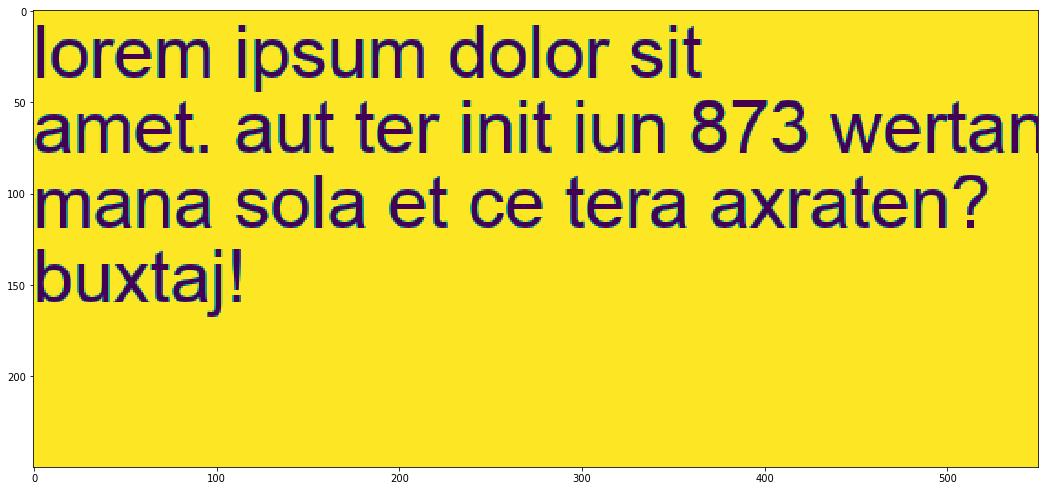

In [104]:
font = 'arial.ttf'
generate_alphabet(font)
generate_ideal_text(font, model_text, (550, 250))
im = imageio.imread("font/arialmodel_ideal.png")
res = recognize(im, font)
plt.imshow(im)
print(res[0], accuracy(res[0], model_text))

Widzimy, że dla tego przypadku algorytm zadziałał prawie poprawnie. Znak kropki został niestey rozpoznany kilkakrotnie i nie w tym miejscu gdzie powinien. Może to wynikać z faktu, że wiele znaków zawiera w sobie kropkę jako podznak, co nie występowało w czcionce szeryfowej.

## Obrócony obraz wejściowy

Innym problemem może być obrócony obraz na wejściu, gdzie musimy sprawdzać więcej przypadków.   
Definiujemy funkcję pozwalającą nam obrócić obrazek i resztę wypełnić białym kolorem. Ze wględu na brak funkcji w bibliotece białym kolorem wypełniamy ręcznie przez co funkcja może nie działać dla innych obrazków niż tekst modelowy.

In [107]:
font = 'arapey-regular.ttf'
generate_alphabet(font)
generate_ideal_text(font, model_text, (550, 270))

In [108]:
def rotate_image(src, ang):
    ss = src.size
    dst = Image.new("L", (ss[0]+300, ss[1] + 300), 255)
    dst.paste(src, (150,150))
    rot = dst.rotate( ang, Image.BICUBIC, expand=1)
    rot = rot.crop((150,150,ss[0]+200, ss[1]+200))
    return rot

In [109]:
rotate_image(Image.open("font/model_ideal.png"), -3).save("font/model_ideal_rotated.png")

Próba zwyczajnego rozpoznania obrazka kończy się niepowodzeniem.

In [111]:
res = recognize(imageio.imread("font/model_ideal_rotated.png"), font)
print(res[0])

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


lk 9 ! m d 4or si
.
9
e
n
u
8
7
3
w
g
e
9 4 ce era xratcn? an
u
p
jq
g
b
b
v
h
h
f
0
y



Aby rozpoznać obrócony obrazek wykonujemy kilka rotacji obrazka i wybieramy tą z najwyższą korelacją.

In [115]:
def recognize_rotated(image_file):
    im1 = Image.open(image_file)
    bs = ""
    bc = 0
    for i in range(-5, 5):
        im2 = rotate_image(im1, i)
        image = np.array(im2.convert("L"))
        txt, cor = recognize(image, font)
        if cor > bc:
            bc = cor
            bs = txt
    return bs

In [117]:
res = recognize_rotated("font/model_ideal_rotated.png")
print(res, accuracy(res, model_text))

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


lore.m lps m do or s
a.me a er it un 873 werta.n
.ma a sola e ce tera axraten? lpqu.
4
b vlh f
b a j a0
y
 0.5053763440860215


Widzimy, że tekst jest w miarę podobny do modelu, jednak występuje też dużo szumów, przez co dokładność nie jest zbyt duża.

## Teksty losowe

Na poprzednim tekście testowałem algorytm w czasie tworzenia. Może to prowadzić do wyspecjalizowania algorytmu dla jednego konkretnego przypadku, czego chcielibyśmy uniknąć. Testujemy zatem algorytm na losowych testach.

In [92]:
def generate_random_text():
    size = random.randint(0,100)
    res = ""
    for i in range(size):
        p = random.randint(0,20)
        if p == 19:
            res += "\n"
        elif p > 17:
            res += " "
        elif p == 16:
            res += chr(random.randint(48,57))
        else:
            res += chr(random.randint(97,122))
    return res

In [93]:
font = 'arapey-regular.ttf'
generate_alphabet(font)
for i in range(5):
    model = generate_random_text()
    generate_ideal_text(font, model, (550, 270))
    res = recognize(imageio.imread("font/arapey-regularmodel_ideal.png"), font)
    print("recognized: ", res[0])
    print("model: ", model)
    print("accuracy: ",accuracy(res[0], model), "\n\n")

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


recognized:  lbv7
bv3zdkwu l
y
edwexgfwosdwxulml e vu ujg

model:  lbv7 
bv3zdkwufyl 
edwexgfwosdwxuhl e vufujg
accuracy:  0.8977272727272727 


recognized:  t0amxxm

model:  txae xxo
accuracy:  0.6875 


recognized:  .
.
idomez

model:  ifoihez
accuracy:  0.4285714285714286 


recognized:  xcayge lh
lv v
kw z
?
yg
7
.
.
rm n 4
b cua8t
d 6
?
9
p q
q

model:  xcayge h
kygv  z
bmcna84
accuracy:  0.14583333333333337 


recognized:  dq0v!pz!pusjv
.nibwvw!paqix.r fe .mcbqxwe9v .nwo
y ! j j
8ulko
?
g
7
.
y
.
ra bd

model:   dqflvpzpusjv 
nibwywpaqixrjfe mcbqxwje9v nwobon3s ksc xiosgsu
8uko
g
yr
ra bd
accuracy:  0.7564102564102564 




Losowe teksty okazały się trudne do rozpoznania dla algorytmu i dokładność nie jest wysoka dla wszystkich zestawów danych. Po analizie przypadków widzimy, że w znacznej większości przypadków wszystkie litery, które powinny być to znalazły się w tekście, występuje jednak dużo dodatkowych liter. Można próbować temu zaradzić dodając znaki na koniec tekstu tak, aby cały alfabet znalazł się w szukanym tekście. 

In [98]:
for i in range(5):
    model = generate_random_text() + "\nqwert uiop\nasdfghyyy klj zxc\nvbnm. 123456789?!"
    generate_ideal_text(font, model, (550, 270))
    res = recognize(imageio.imread("font/arapey-regularmodel_ideal.png"), font)
    print("recognized: ", res[0])
    print("model: ", model)
    print("accuracy: ",accuracy(res[0], model), "\n\n")

/home/arkadius/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)
/home/arkadius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


recognized:  ?
. . .
. .
. . .
v l mrlh v fm
boax bsbke x x
0
9 9
? ?
3 3
g gyy
glh.njo
bctgjxuq.m
wbfo
lhg iwow
qwe.rt uio!p
.
f lhvvvll
asd k zxc

model:  boaxv bsbkegxmrhxgyyfm
ghnjo
 bctgjxuqm
wbfo
hgviwow
qwert uiop
asdfghyyy klj zxc
vbnm. 123456789?!
accuracy:  0.5252525252525253 


recognized:  ?
qutdlhv!p.m!p9lhalkzi iov lhlhqjbt.r.n!pd
id
.
.
.
n
x
?
g
glkb!pwxzjhjd.mwyv8.nifqjwo
qwe.rt uio!p
.
f lhvvvll
asd k zxc

model:   
utdhvpmp9hakzi  iov7hhqjbtrnpdqjmxqysd4s09uf  spekjomw
id
nxg
gkbpwxzjfhjdmwyv8nifqjwo
qwert uiop
asdfghyyy klj zxc
vbnm. 123456789?!
accuracy:  0.7037037037037037 


recognized:  li l l f lh r l l i nf
b b z u b dd ta kc9k b
g j y g g
pw5lumomaos yex
9edaje
wrm r fllw w
d s z 6da kk t
q
g j j
qwert uiop
f lhvvvll
asd k zxc
0
g yyy j
.
.
v nm 1 4
b . 23t56789?!

model:  b bligzlul f  hbjrdd taykc9kgbg i nfv1 qb
pw5lumomaos yex
9edaje 
dw rm sgz 6da qrjf kkwjtw 
qwert uiop
asdfghyyy klj zxc
vbnm. 123456789?!
accuracy:  0.6510791366906474 


recognized:  5ra

Wyniki są niewiele lepsze. Nadal widać, że heurystyczne algorytmy redukcji i filtrowania nie działają najlepiej dla losowych danych. Literki zostały rozpoznane poprawnie jednak nadal jest dużo szumów.

Podsumowując widzimy, że algorytm rozpoznawania zadanych znaków za pomocą liczenia splotu działa dobrze. Problemem jest jednak połącznie rozpoznanych liter w ciągły tekst i usunięcie szumów (literowych), które powstają gdy nie ma jakiejś z liter. Dla konkretnych przypadków może on działać wystarczająco dobrze, jednak dla testów losowych widzimy, że algorytm filtracji jest heurystyczny i nie daje najlepszych rezultatów. Uzyskane wyniki są podobne do zeskanowych tekstów, które uzyskiwałem gdy kilka lat temu zainstalowałem pierwszy raz skaner OCR na telefon. 

Można byłoby próbować zmieniać algorytm filtracji tak aby dopasowywał powyżej zadanej korelacji, jednak mogłoby to być problematyczne przy gdy jakość zdjęć jest mniejsza i wszystkie korelacje spadają.